# CIFAR10 dataset
The CIFAR10 dataset consists of $60,000$ $32\times 32$ images that fall on one of $10$ categories and is one of the most popular image datasets, along with MNIST, for beginner's image classification. Here we train a simple Convolutional Neural Network (CNN) for classifying the images in the CIFAR10 dataset.

In [395]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

In [93]:
# Device configuration: check if CUDA is available
# My local device does not

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

We first define some image transformation. The CIFAR10 images are of the PIL format, which cannot be handled by PyTorch. These images are represented by $32\times 32\times 3$ matrices, where the last $3$ indicates the R, G and B color channels with pixel values in the range $[0, 255]$. In order for these to be handle by PyTorch, we use the transforms.ToTensor() method to convert them into arrays in the range $[0,1]$. A final transform normalizes the pixel values.

When importing the dataset, we create a train and validation split of sizes $45000$ and $5000$ such that the training and validation steps can be kept track of in the same loop. The learning rate $\eta$ and batch size are hyper-parameters that can be tuned to improve the performance of the model. Here, we use $\eta=5\times 10^{-4}$ and $\rm{batch\_size}=16$.

In [95]:
# Hyper-parameters
learning_rate = 0.0005
batch_size = 16

'''
The dataset has PILImage images of range [0, 1]. The dataset is transformed to
tensors of normalized range [-1, 1]
'''

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # 3 channels in the CIFAR 10 images
    ]
)

train_dataset, valid_dataset = random_split(
    torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform
    ), [45000, 5000]
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

print(f'Size of the train and validation sets are {len(train_dataset)} and {len(valid_dataset)}.')
print(f'Size of the test dataset is {len(test_dataset)}.')


'''
The dateloader objects contain tensors of shape (4 x 3 x 32 x 32) where
4 is the batch_size, 3 is the RGB channel and 32 x 32 are the pixels.
'''

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

classes = {
    '0' : 'airplane',
    '1' : 'automobile',
    '2' : 'bird',
    '3' : 'cat',
    '4' : 'deer',
    '5' : 'dog',
    '6' : 'frog',
    '7' : 'horse',
    '8' : 'ship',
    '9' : 'truck'
}

Files already downloaded and verified
Files already downloaded and verified
Size of the train and validation sets are 45000 and 5000.
Size of the test dataset is 10000.


In [96]:
test_dataset.classes 

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

We check the training and validation sets to see if they, in general, have a good random mix of the different classes of images.

Sample images from training set

Sample images from validation set



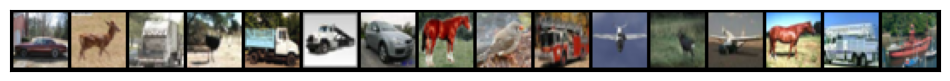

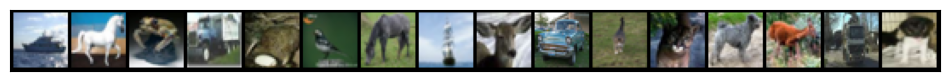

In [98]:
def show_batch(dataloader):
    for image, _ in dataloader:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]), ax.set_yticks([])
        ax.imshow(make_grid(image, nrow=16, normalize=True).permute(1, 2, 0))
        break

print('Sample images from training set\n')
show_batch(train_loader)
print('Sample images from validation set\n')
show_batch(valid_loader)

Apart from the shape of the input, the shape of the output of a convolution operation depends on 
1. kernel size $(K)$
2. padding $(P)$
3. stride $(S)$

The kernel size is important in capturing detail since it averages the pixel information to create a feature map. For example, smaller kernel sizes will be able to capture finer details. One the other hand, larger kernel sizes will be able to capture broader details. After convolution, an image of width $W$ gets transformed into
$$ W_{\rm{conv}} = \frac{W-K+2P}{S} + 1 $$
The number of output channels after convolution is arbitrary depends on user specification. It is important to calculate the array dimensions after passage through each convolution and pooling layer since it will be the number of input features in the first linear layer following convolutions.

A neural network of three convolutional (and max pooling) layers followed by two fully connected layers is used. The image dimension calculations are as follows:
1. The input image matrices are of dimension $B\times 3 \times 32 \times 32$, where $B$ is the batch size (not important in the grand scheme of things). The three RGB channels will form the $3$ $\rm{in\_channels}$ in *conv1* producing $16$ $\rm{out\_channels}$. With $\rm{kernel\_size}=3$ and $\rm{stride}=\rm{padding}=1$ (which will remain constant throughout), the image shape will remain unchanged. As a result, the shape gets transformed to $B\times 16\times 32\times 32$.
2. The max pooling layers have $\rm{kernel\_size}=\rm{stride}=2$, which reduces the shape to $B\times16\times16\times 16$.
3. In *conv2*, $\rm{in\_channel}=16$ and $\rm{out\_channel}=32$. The convolution does not alter the shape further, which is now $B\times32\times16\times16$.
4. The second max pooling layer reduces the shape to $B\times32\times8\times8$.
5. In *conv3*, $\rm{in\_channel}=32$ and $\rm{out\_channel}=64$. The convolution does not alter the shape further, which is now $B\times64\times8\times8$.
6. The final max pooling layer reduces the shape to $B\times 64\times4\times4$. This shape is flattened to an single dimensional array of size $1024$, which becomes the input for the first fully-connected layer.

In [100]:
class ConvNet(nn.Module):
    
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1   = nn.Linear(64*4*4, 100)
        self.fc2   = nn.Linear(100, 10)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x))) # 1st convolution and pooling layers
        x = self.pool2(F.relu(self.conv2(x))) # 2nd convolution and pooling layers
        x = self.pool3(F.relu(self.conv3(x))) # 3rd convolution and pooling layers
        x = x.view(-1, 64*4*4) # Flattened image tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

The 'CrossEntropyLoss' criterion is used to calculate the loss at each epoch. The cross-entropy is a method for comparing two probability distributions and is defined as
$$ H(P,Q) = \sum_{x}P(x)\log Q(x) $$
where $P(x)$ and $Q(x)$ are two discrete probability distributions representing the probabilities of the true class labels and the predicted labels and $x\in X$ is the sample space of events. In our image classification task 
$$ X = \left[ 0,9 \right] $$
where the correspondences between image classes has already been established. The task of the stochastic gradient descent (SGD) optimizer is to minimize the cross-entropy loss function $H(P,Q)$, which occurs when the prediction probabilities started approaching the true class probabilities.

A training function is created which takes in the dataloader, CNN model, loss function, optimizer and number of epochs as arguments. The function contains an epoch loop under which the training and validation dataloaders are iterated over. For training and validation, the loss and accuracy are also collected at each epoch.

In [101]:
'''  
Using the Cross Entropy loss function and Stochastic Gradient Descent optimizer
'''
model = ConvNet().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

def train(train_dl, valid_dl, model, loss_fn, optimizer, num_epochs):
    train_size = len(train_dl.dataset)
    valid_size = len(valid_dl.dataset)
    loss_train = [] # Loss history per epoch during training
    acc_train  = [] # Accuracy history per epoch during training
    loss_valid = [] # Loss history per epoch during validation
    acc_valid  = [] # Accuracy history per epoch during validation
   
    model.train()
    
    for epoch in range(num_epochs):
        ''' 
        Training phase
        '''
        running_loss = 0.0
        running_correct = 0 # Keeps track of the number of correct classifications
        running_total = 0
        for image, label in tqdm(train_dl, desc='Training loop'):
            image, label = image.to(device), label.to(device)
            
            '''  
            Calculate prediction and loss function per epoch
            '''
            output = model(image)
            loss = loss_fn(output, label)
            ''' 
            Backpropagating the loss function to re-adjust weights
            '''
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()*image.size(0) # Accumulated loss per training batch
            _, predicted = torch.max(output, dim=1)
            running_total += label.size(0)
            running_correct += (predicted == label).sum().item()

        training_loss = running_loss/train_size
        loss_train.append(training_loss)
        training_accuracy = running_correct/running_total # Proportion of accurate predictions 
        acc_train.append(training_accuracy)

        ''' 
        Validation phase
        '''
        model.eval()
        running_loss = 0.0
        running_correct = 0 # Keeps track of the number of correct classifications
        running_total = 0

        with torch.no_grad():
            for image, label in tqdm(valid_dl, desc='Validation loop'):
                image, label = image.to(device), label.to(device)
                output = model(image)
                loss = loss_fn(output, label)
                
                running_loss += loss.item()*image.size(0) # Accumulated loss per validation batch
                _, predicted = torch.max(output dim=1)
                running_total += label.size(0)
                running_correct += (predicted == label).sum().item()
        validation_loss = running_loss/valid_size 
        loss_valid.append(validation_loss)
        validation_accuracy = running_correct/running_total
        acc_valid.append(validation_accuracy)

        # Epoch statistics
        print(f'Epoch {epoch+1}/{num_epochs}: trainining loss = {training_loss:4f}, training accuracy = {training_accuracy:4f},\
               validation loss = {validation_loss:4f}, validation accuracy = {validation_accuracy:4f}')
    
    return loss_train, acc_train, loss_valid, acc_valid 

In [102]:
# Training the model for 20 epochs

loss_train, acc_train, loss_valid, acc_valid = train(train_loader, valid_loader, model, loss_fn, optimizer, num_epochs=20)

Training loop:   0%|          | 0/2813 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1/20: trainining loss = 2.182742, training accuracy = 0.199022,               validation loss = 1.954853, validation accuracy = 0.308600


Training loop:   0%|          | 0/2813 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2/20: trainining loss = 1.752407, training accuracy = 0.368533,               validation loss = 1.638987, validation accuracy = 0.402000


Training loop:   0%|          | 0/2813 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3/20: trainining loss = 1.501310, training accuracy = 0.455800,               validation loss = 1.417915, validation accuracy = 0.479800


Training loop:   0%|          | 0/2813 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4/20: trainining loss = 1.378147, training accuracy = 0.499711,               validation loss = 1.310911, validation accuracy = 0.527000


Training loop:   0%|          | 0/2813 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5/20: trainining loss = 1.276962, training accuracy = 0.541800,               validation loss = 1.238977, validation accuracy = 0.563000


Training loop:   0%|          | 0/2813 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6/20: trainining loss = 1.190334, training accuracy = 0.574689,               validation loss = 1.162339, validation accuracy = 0.593000


Training loop:   0%|          | 0/2813 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7/20: trainining loss = 1.112372, training accuracy = 0.604600,               validation loss = 1.105517, validation accuracy = 0.607400


Training loop:   0%|          | 0/2813 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8/20: trainining loss = 1.044934, training accuracy = 0.631000,               validation loss = 1.060734, validation accuracy = 0.623400


Training loop:   0%|          | 0/2813 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9/20: trainining loss = 0.989770, training accuracy = 0.650156,               validation loss = 1.031815, validation accuracy = 0.630200


Training loop:   0%|          | 0/2813 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10/20: trainining loss = 0.934618, training accuracy = 0.671778,               validation loss = 0.971605, validation accuracy = 0.659800


Training loop:   0%|          | 0/2813 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 11/20: trainining loss = 0.885843, training accuracy = 0.688511,               validation loss = 0.936110, validation accuracy = 0.667200


Training loop:   0%|          | 0/2813 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 12/20: trainining loss = 0.843998, training accuracy = 0.705067,               validation loss = 0.920526, validation accuracy = 0.676400


Training loop:   0%|          | 0/2813 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 13/20: trainining loss = 0.805024, training accuracy = 0.719200,               validation loss = 0.911210, validation accuracy = 0.671200


Training loop:   0%|          | 0/2813 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 14/20: trainining loss = 0.767681, training accuracy = 0.730822,               validation loss = 0.888453, validation accuracy = 0.686800


Training loop:   0%|          | 0/2813 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15/20: trainining loss = 0.734551, training accuracy = 0.743533,               validation loss = 0.907546, validation accuracy = 0.686200


Training loop:   0%|          | 0/2813 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 16/20: trainining loss = 0.696712, training accuracy = 0.760089,               validation loss = 0.837210, validation accuracy = 0.706600


Training loop:   0%|          | 0/2813 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 17/20: trainining loss = 0.665708, training accuracy = 0.769867,               validation loss = 0.864323, validation accuracy = 0.693800


Training loop:   0%|          | 0/2813 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 18/20: trainining loss = 0.631677, training accuracy = 0.778911,               validation loss = 0.825132, validation accuracy = 0.714200


Training loop:   0%|          | 0/2813 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 19/20: trainining loss = 0.603756, training accuracy = 0.789422,               validation loss = 0.838246, validation accuracy = 0.715000


Training loop:   0%|          | 0/2813 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20/20: trainining loss = 0.571243, training accuracy = 0.800022,               validation loss = 0.855678, validation accuracy = 0.710400


After the model has been trained for $20$ epochs, the loss and accuracy of the training and validations sets are plotted. It can be seen that the validation accuracy starts to plateau for this model at around $70\%$ and it is possible that when trained for more epochs it might start decreasing, indicating the presence of *overfitting*.

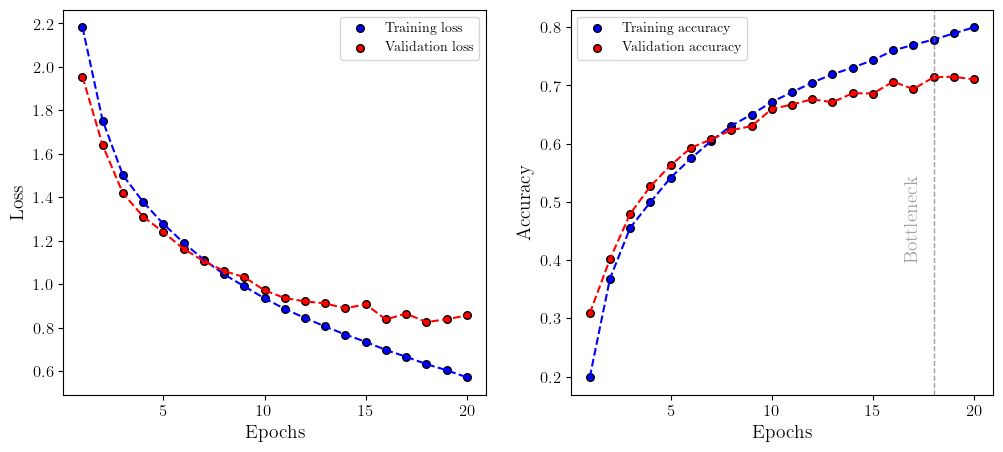

In [154]:
epochs = np.arange(1, 21)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].scatter(epochs, loss_train, c='blue', s=30, edgecolor='black', label='Training loss')
ax[0].plot(epochs, loss_train, c='blue', linestyle='dashed')
ax[0].scatter(epochs, loss_valid, c='red', s=30, edgecolor='black', label='Validation loss')
ax[0].plot(epochs, loss_valid, c='red', linestyle='dashed')
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Loss', fontsize=14)

ax[1].scatter(epochs, acc_train, c='blue', s=30, edgecolor='black', label='Training accuracy')
ax[1].plot(epochs, acc_train, c='blue', linestyle='dashed')
ax[1].scatter(epochs, acc_valid, c='red', s=30, edgecolor='black', label='Validation accuracy')
ax[1].plot(epochs, acc_valid, c='red', linestyle='dashed')
ax[1].axvline(18, linestyle='dashed', linewidth=1, color='gray', alpha=0.75)
ax[1].annotate('Bottleneck', (16.5, 0.4), fontsize=14, color='gray', alpha=0.75, rotation=90)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[0].legend()
ax[1].legend()
plt.show()

For checking the predictions, both during validation and testing, the dataloaders are iterated over. After the image tensors are passed through the model, the resulting tensor will have shape $B\times 10$, where $10$ is the number of class labels. Each of the $B$ rows contains class probabilities in the mini-batch
$$ \left( \begin{array}{cc} p_{0,0} & p_{0,1} & \cdots & p_{0,9} \\ p_{1,0} & p_{1,1} & \cdots & p_{1,9} \\ \vdots & \vdots & \ddots & \vdots \\ p_{B-1,0} & p_{B-1,1} & \cdots & p_{B-1,9} \end{array}\right) $$
The operation torch.max(..., dim=1) finds the index of the highest occuring element across each row, i.e. highest predicted probability of a class,, returning a $10d$ array which is finally compared with the actual labels and the number of corrected predictions calculated. This is subsequently iterated over all the mini-batches.

In [342]:
def test(test_dl, model):
    running_correct = 0
    running_total = 0

    with torch.no_grad():
        for image, label in test_dl:
            image, label = image.to(device), label.to(device)
            output = model(image)

            _, predicted = torch.max(output.data, dim=1)
            running_total += label.size(0)
            running_correct += (predicted == label).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

test(test_loader, model)

Accuracy of the network on the 10000 test images: 71 %


In [407]:
@torch.no_grad()
def get_confusion_matrix(test_dl, model):
    # Defining a function for calculating the confusion matrix
    # Require the total number of true and prediction labels in each category

    all_preds = torch.Tensor([])

    for image, label in test_dl:
        image, label = image.to(device), label.to(device)
        output = model(image)

        all_preds = torch.cat((all_preds, output.data), dim=0) # vertically stacks all outputs from iterations

    '''
    Converting the PyTorch tensors into numpy arrays
    '''
    all_preds = torch.max(all_preds, dim=1).indices.numpy()
    all_labels = torch.Tensor(test_dataset.targets).numpy()
    
    return confusion_matrix(all_labels, all_preds)

CM = get_confusion_matrix(test_loader, model)

print(CM)

[[775  12  33  15   7   6   9  10  82  51]
 [ 17 809   0   4   1   2   4   7  35 121]
 [ 94  12 574  45  66  48  67  65  16  13]
 [ 35  22  59 466  48 140  93  77  28  32]
 [ 39   9  63  59 552  22  79 147  23   7]
 [ 28  10  41 139  27 584  42  99  16  14]
 [ 13  11  34  32  20  12 848   9  14   7]
 [ 12  12  27  32  26  30  15 827   4  15]
 [ 50  40   4  10   2   4   4   6 847  33]
 [ 30  71   6   9   1   5   7  15  31 825]]


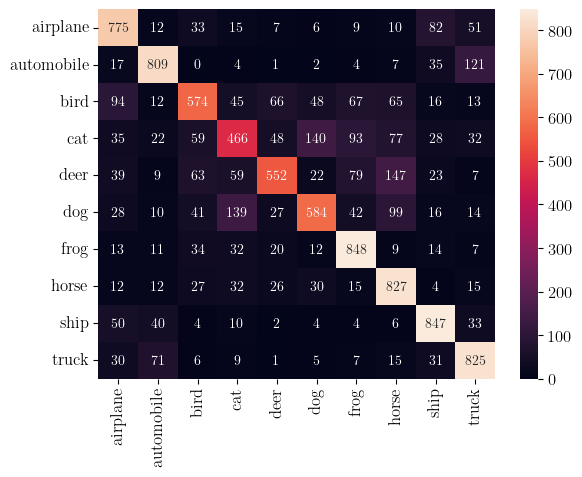

In [415]:
class_labels = [
        'airplane',
        'automobile',
        'bird',
        'cat',
        'deer',
        'dog',
        'frog',
        'horse',
        'ship',
        'truck'
    ]

sns.heatmap(CM, annot=True, fmt='.3g', xticklabels=class_labels, yticklabels=class_labels)
plt.show()